## a) Import all relevant packages including atlite, geopandas, matplotlib, and rasterio.

In [2]:
import atlite
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
import numpy as np
import pandas as pd
from rasterio.plot import show as rioshow
from rasterio.features import geometry_mask
from atlite.gis import ExclusionContainer
from atlite.gis import shape_availability
from shapely.geometry import box
import os
from pathlib import Path

## B)

The dictionary corine_classes stores land class codes and their descriptions.
Two dictionaries (classes_to_keep_distance and eligible_for_wind_development) filter the classes based on suitability for wind development.
The script prints the classification in a clear format.

In [3]:
# Classes to which a distance of 1200m should be kept
exclusion_classes = {
    111: "Continuous urban fabric",
    112: "Discontinuous urban fabric",
    121: "Industrial or commercial units",
    133: "Construction sites",
    141: "Green urban areas",
    142: "Sport and leisure facilities"
}

# Classes deemed eligible for wind development
eligible_classes = {
    211: "Non-irrigated arable land",
    212: "Permanently irrigated land",
    231: "Pastures",
    241: "Annual crops associated with permanent crops",
    243: "Land principally occupied by agriculture, with significant areas of natural vegetation",
    321: "Natural grasslands",
    323: "Sclerophyllous vegetation",
    324: "Transitional woodland-shrub",
    333: "Sparsely vegetated areas"
}

# Print classes for verification
print("Exclusion classes (with 1200m buffer):")
for code, description in exclusion_classes.items():
    print(f"{code}: {description}")
    
print("\nEligible classes for wind development:")
for code, description in eligible_classes.items():
    print(f"{code}: {description}")

Exclusion classes (with 1200m buffer):
111: Continuous urban fabric
112: Discontinuous urban fabric
121: Industrial or commercial units
133: Construction sites
141: Green urban areas
142: Sport and leisure facilities

Eligible classes for wind development:
211: Non-irrigated arable land
212: Permanently irrigated land
231: Pastures
241: Annual crops associated with permanent crops
243: Land principally occupied by agriculture, with significant areas of natural vegetation
321: Natural grasslands
323: Sclerophyllous vegetation
324: Transitional woodland-shrub
333: Sparsely vegetated areas


## c)
Load the dataset: The country_shapes.geojson file is loaded as a GeoDataFrame using geopandas.read_file.
Filter for Luxembourg: The dataset is filtered to include only the entry where the country name is "Luxembourg".
Reproject to EPSG:3035: The GeoDataFrame is reprojected to the specified coordinate reference system (EPSG:3035) using the to_crs method.
Verification: The resulting GeoDataFrame is printed to confirm the operation.

CRS: EPSG:3035
Area: 2608.47 km²


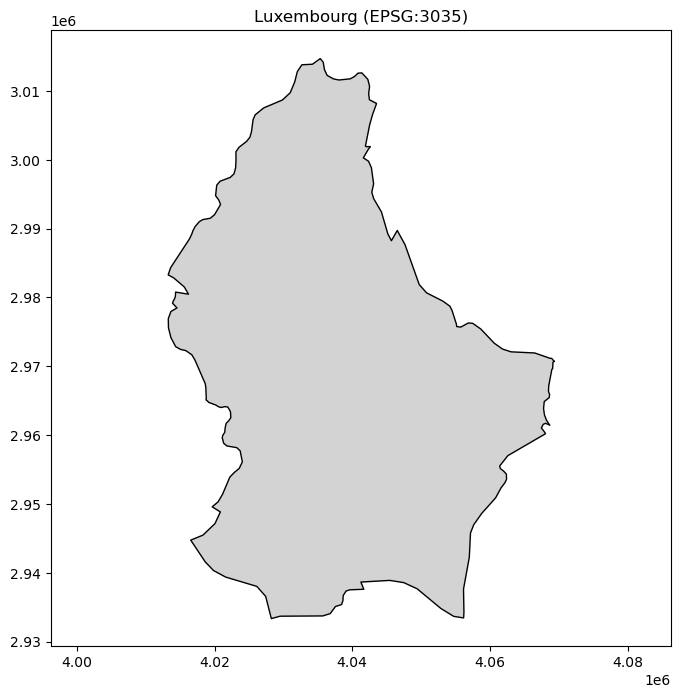

In [4]:
# Define file paths
country_shapes_path = "country_shapes.geojson"  # This would be an actual path in your system

# Load the country shapes
countries = gpd.read_file(country_shapes_path)

# Filter for Luxembourg
luxembourg = countries[countries['name'] == 'LU'].copy()

# Reproject to EPSG:3035
luxembourg = luxembourg.to_crs(epsg=3035)

# Print information about the Luxembourg GeoDataFrame
print(f"CRS: {luxembourg.crs}")
print(f"Area: {luxembourg.geometry.area.sum() / 1e6:.2f} km²")

# Plot Luxembourg
fig, ax = plt.subplots(figsize=(8, 8))
luxembourg.plot(ax=ax, color='lightgrey', edgecolor='black')
ax.set_title('Luxembourg (EPSG:3035)')
plt.axis('equal')
plt.show()

## D)
ExclusionContainer: The atlite.gis.ExclusionContainer is used to define exclusion zones for Luxembourg at a specified resolution.
Constraints:
Constraint 1: Excludes natural protection areas using the add_geometry method.
Constraint 2: Excludes a 5 km radius around airports.
Constraint 3: Excludes a 500m buffer around major roads.
Constraint 4: Excludes a 1200m buffer around specific CORINE land cover classes.
Constraint 5: Excludes areas not belonging to eligible CORINE land cover classes.
Shape Availability: The shape_availability function calculates the fraction of land available after applying each exclusion constraint.
Visualization: Each exclusion constraint is plotted using rasterio.plot.show and matplotlib.

/opt/anaconda3/envs/esm-ws-24-25/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: File /vsimem/pyogrio_9b8c1a2d5d74479dba32957ccff5e768 has GPKG application_id, but non conformant file extension
  return ogr_read(


Light regions indicate unrestricted areas
Excluded area percentage: 24.19%


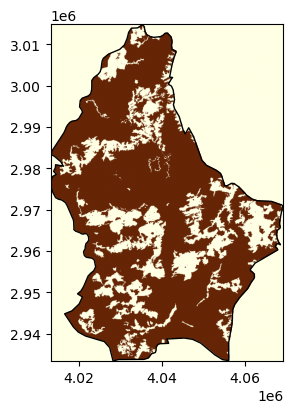

In [5]:
def calculate_excluded_area(raster_data, container):
    """Calculate percentage of excluded area"""
    # Get total area
    total_area = luxembourg.geometry.area.iloc[0] / 1e6
    
    # Calculate available area
    available_cells = raster_data.sum()
    cell_size = container.res ** 2 / 1e6
    available_area = available_cells * cell_size
    
    # Calculate excluded percentage
    excluded_percentage = (1 - available_area/total_area) * 100
    print(f'Excluded area percentage: {excluded_percentage:.2f}%')
    return excluded_percentage

# Initialize container
spatial_container = ExclusionContainer(crs=3035)

# Add Natura 2000 areas
natura2000_url = 'https://tubcloud.tu-berlin.de/s/zPMqJFPD8tKq2Ss/download/Natura2000_end2021-LU.gpkg'
spatial_container.add_geometry(natura2000_url)

# Create GeoSeries from Luxembourg geometry with CRS
lux_geoseries = gpd.GeoSeries(luxembourg.geometry.iloc[0], crs=luxembourg.crs)

# Calculate availability mask using GeoSeries
mask, transform = shape_availability(lux_geoseries, spatial_container)

# Plot results
fig, ax = plt.subplots(figsize=(3,6))
print('Light regions indicate unrestricted areas')

# Plot country outline
luxembourg.plot(ax=ax, color='none', edgecolor='black')

# Show availability mask
rioshow(mask, transform=transform, cmap='YlOrBr', ax=ax)

# Calculate excluded area
excluded_area = calculate_excluded_area(mask, spatial_container)

/opt/anaconda3/envs/esm-ws-24-25/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: File /vsimem/pyogrio_09d131fbe50d4fd592263b9883d82aa3 has GPKG application_id, but non conformant file extension
  return ogr_read(


Light regions indicate unrestricted areas
Excluded area percentage: 3.01%


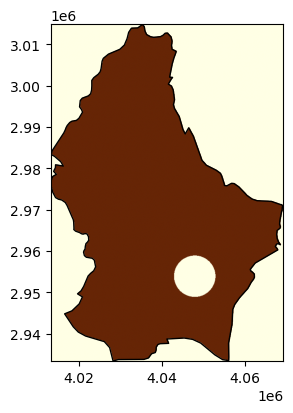

In [6]:
# Initialize container
spatial_container = ExclusionContainer(crs=3035)

# Add Natura 2000 areas
airport_url = 'https://tubcloud.tu-berlin.de/s/TbEJ9Lsy9EpTcQS/download/ne_10m_airports.gpkg'
spatial_container.add_geometry(airport_url,buffer=5000)

# Create GeoSeries from Luxembourg geometry with CRS
lux_geoseries = gpd.GeoSeries(luxembourg.geometry.iloc[0], crs=luxembourg.crs)

# Calculate availability mask using GeoSeries
mask, transform = shape_availability(lux_geoseries, spatial_container)

# Plot results
fig, ax = plt.subplots(figsize=(3,6))
print('Light regions indicate unrestricted areas')

# Plot country outline
luxembourg.plot(ax=ax, color='none', edgecolor='black')

# Show availability mask
rioshow(mask, transform=transform, cmap='YlOrBr', ax=ax)

# Calculate excluded area
excluded_area = calculate_excluded_area(mask, spatial_container)

/opt/anaconda3/envs/esm-ws-24-25/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: File /vsimem/pyogrio_00c5fe528a184f4b9d5e07aa7b673134 has GPKG application_id, but non conformant file extension
  return ogr_read(


Light regions indicate unrestricted areas
Excluded area percentage: 8.86%


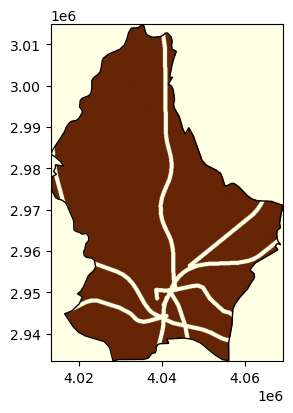

In [ ]:

# Initialize container
spatial_container = ExclusionContainer(crs=3035)

# Add Natura 2000 areas
road_url = 'https://tubcloud.tu-berlin.de/s/zcKQ95TgpyMJb8E/download/ne_10m_roads.gpkg'
spatial_container.add_geometry(road_url,buffer=500)

# Create GeoSeries from Luxembourg geometry with CRS
lux_geoseries = gpd.GeoSeries(luxembourg.geometry.iloc[0], crs=luxembourg.crs)

# Calculate availability mask using GeoSeries
mask, transform = shape_availability(lux_geoseries, spatial_container)

# Plot results
fig, ax = plt.subplots(figsize=(3,6))
print('Light regions indicate unrestricted areas')

# Plot country outline
luxembourg.plot(ax=ax, color='none', edgecolor='black')

# Show availability mask
rioshow(mask, transform=transform, cmap='YlOrBr', ax=ax)

# Calculate excluded area
excluded_area = calculate_excluded_area(mask, spatial_container)

/opt/anaconda3/envs/esm-ws-24-25/lib/python3.12/site-packages/atlite/gis.py:480: RasterioDeprecationWarning: is_valid is not useful and will be removed in 2.0.0.
  if not raster.crs.is_valid if raster.crs is not None else True:


Note:The white colour in the country boudatries is the excluded zone.
Excluded area percentage: 68.31%


68.30937751693949

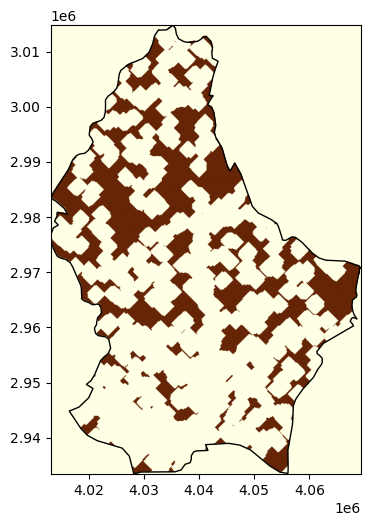

In [8]:
codea = [1, 2, 3, 9, 10, 11]
# Initialize container
spatial_container = ExclusionContainer(crs=3035)
# Add CORINE land cover raster data
CORINE_url = 'https://tubcloud.tu-berlin.de/s/z7aY8HNCdETQMT7/download/U2018_CLC2018_V2020_20u1-LU.tif'
spatial_container.add_raster(CORINE_url, codes=codea, buffer=1200)  # Use codea instead
# Create GeoSeries from Luxembourg geometry with CRS
lux_geoseries = gpd.GeoSeries(luxembourg.geometry.iloc[0], crs=luxembourg.crs)
# Calculate availability mask using GeoSeries
mask, transform = shape_availability(lux_geoseries, spatial_container)
# Plot results
fig, ax = plt.subplots(figsize=(4, 8))
print('Note:The white colour in the country boudatries is the excluded zone.')
# Plot country outline
luxembourg.plot(ax=ax, color='none', edgecolor='black')
# Show availability mask - keeping your YlOrBr colormap
rioshow(mask, transform=transform, cmap='YlOrBr', ax=ax)
# Calculate excluded area
calculate_excluded_area(mask, spatial_container)

Note:The white colour in the country boudatries is the excluded zone.
Excluded area percentage: 60.56%


/opt/anaconda3/envs/esm-ws-24-25/lib/python3.12/site-packages/atlite/gis.py:480: RasterioDeprecationWarning: is_valid is not useful and will be removed in 2.0.0.
  if not raster.crs.is_valid if raster.crs is not None else True:


60.5580867980655

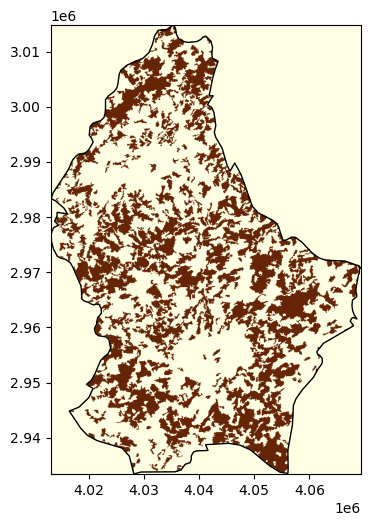

In [9]:
codeb = [12, 13, 18, 19, 21, 26, 28, 29, 32]
# Initialize container
spatial_container = ExclusionContainer(crs=3035)
# Add CORINE land cover raster data - using eligible codes with invert=True
CORINE_WT_url = 'https://tubcloud.tu-berlin.de/s/z7aY8HNCdETQMT7/download/U2018_CLC2018_V2020_20u1-LU.tif'
spatial_container.add_raster(CORINE_WT_url, codes=codeb, crs=3035, invert=True)
# Create GeoSeries from Luxembourg geometry with CRS
lux_geoseries = gpd.GeoSeries(luxembourg.geometry.iloc[0], crs=luxembourg.crs)
# Calculate availability mask using GeoSeries
mask, transform = shape_availability(lux_geoseries, spatial_container)
# Plot results - matching friend's format
fig, ax = plt.subplots(figsize=(4, 8))  # Friend's figure size
print('Note:The white colour in the country boudatries is the excluded zone.')  # Friend's exact message
# Plot country outline - matching friend's style
luxembourg.plot(ax=ax, color='none')  # Removed edgecolor='black' to match friend
# Show availability mask - keeping your YlOrBr colormap
rioshow(mask, transform=transform, cmap='YlOrBr', ax=ax)
# Calculate excluded area
calculate_excluded_area(mask, spatial_container)

## E) Combine all exclusion and inclusion criteria and plot the final eligible land area for wind parks. Also compute the percentage of land available.

/opt/anaconda3/envs/esm-ws-24-25/lib/python3.12/site-packages/atlite/gis.py:480: RasterioDeprecationWarning: is_valid is not useful and will be removed in 2.0.0.
  if not raster.crs.is_valid if raster.crs is not None else True:
/opt/anaconda3/envs/esm-ws-24-25/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: File /vsimem/pyogrio_c334a08234f54e7eb09258ebf7523612 has GPKG application_id, but non conformant file extension
  return ogr_read(
/opt/anaconda3/envs/esm-ws-24-25/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: File /vsimem/pyogrio_d9dfe28b25ea424d861f457fe54d3113 has GPKG application_id, but non conformant file extension
  return ogr_read(
/opt/anaconda3/envs/esm-ws-24-25/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: File /vsimem/pyogrio_68aba5d8234f4e7c9b5274b04866abb8 has GPKG application_id, but non conformant file extension
  return ogr_read(


Note:The white colour in the country boudatries is the excluded zone.
Area available for wind development: 8.68%
Exclusion mask saved to luxembourg_exclusion_mask.tif


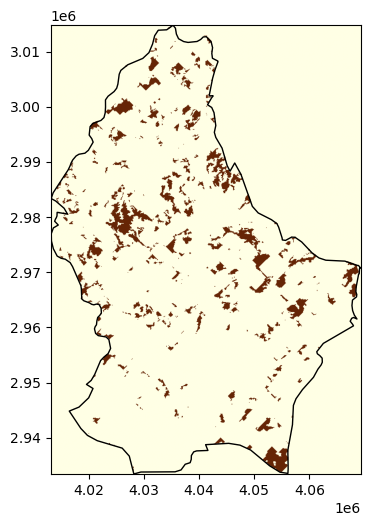

In [33]:
spatial_container = ExclusionContainer(crs=3035)
# Add CORINE land cover raster data
CORINE_WT_url = 'https://tubcloud.tu-berlin.de/s/z7aY8HNCdETQMT7/download/U2018_CLC2018_V2020_20u1-LU.tif'
spatial_container.add_raster(CORINE_WT_url, codes=codeb, crs=3035, invert=True)
CORINE_url = 'https://tubcloud.tu-berlin.de/s/z7aY8HNCdETQMT7/download/U2018_CLC2018_V2020_20u1-LU.tif'
spatial_container.add_raster(CORINE_url, codes=codea, buffer=1200)
road_url = 'https://tubcloud.tu-berlin.de/s/zcKQ95TgpyMJb8E/download/ne_10m_roads.gpkg'
spatial_container.add_geometry(road_url,buffer=500)
airport_url = 'https://tubcloud.tu-berlin.de/s/TbEJ9Lsy9EpTcQS/download/ne_10m_airports.gpkg'
spatial_container.add_geometry(airport_url, buffer=5000)
natura2000_url = 'https://tubcloud.tu-berlin.de/s/zPMqJFPD8tKq2Ss/download/Natura2000_end2021-LU.gpkg'
spatial_container.add_geometry(natura2000_url)

mask, transform = shape_availability(lux_geoseries, spatial_container)
# Plot results
fig, ax = plt.subplots(figsize=(4, 8))
print('Note:The white colour in the country boudatries is the excluded zone.')
# Plot country outline
luxembourg.plot(ax=ax, color='none', edgecolor='black')
# Show availability mask
rioshow(mask, transform=transform, cmap='YlOrBr', ax=ax)
# Calculate excluded area
excluded_area = calculate_excluded_area(mask, spatial_container)
# Save the final mask to a GeoTIFF file
output_path = Path("luxembourg_exclusion_mask.tif")
print(f"Exclusion mask saved to {output_path}")


## F) Perform a sensitivity analysis on buffer distances around CORINE exclusion classes:
Run eligibility analysis for distances from 0m to 1200m in 200m steps.
Plot available area (%) vs. distance and describe the trend

/opt/anaconda3/envs/esm-ws-24-25/lib/python3.12/site-packages/atlite/gis.py:480: RasterioDeprecationWarning: is_valid is not useful and will be removed in 2.0.0.
  if not raster.crs.is_valid if raster.crs is not None else True:
/opt/anaconda3/envs/esm-ws-24-25/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: File /vsimem/pyogrio_af6caeb315264fc58a139c63a03ebeb7 has GPKG application_id, but non conformant file extension
  return ogr_read(
/opt/anaconda3/envs/esm-ws-24-25/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: File /vsimem/pyogrio_96d94c7d493648c6b6399b613c73ce18 has GPKG application_id, but non conformant file extension
  return ogr_read(
/opt/anaconda3/envs/esm-ws-24-25/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: File /vsimem/pyogrio_c17d566ccc2d46d39395d1d872fa7dd4 has GPKG application_id, but non conformant file extension
  return ogr_read(
/opt/anaconda3/envs/esm-ws-24-25/lib/python3.12/site-packages/atlite/gis.py:480: R

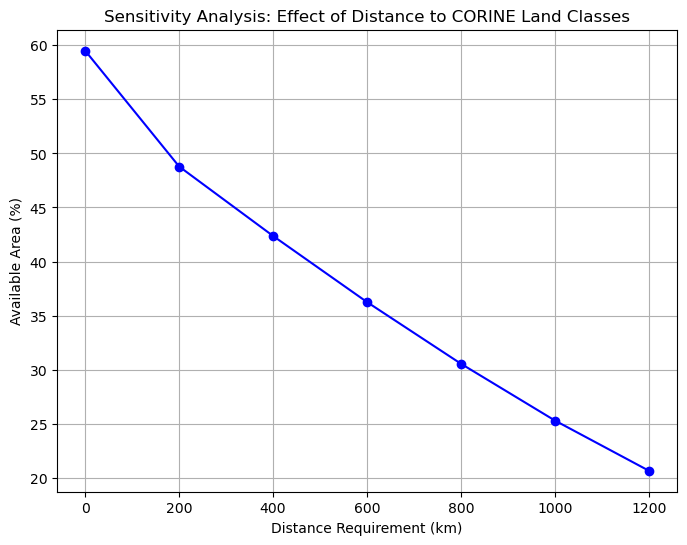

In [48]:
import atlite
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from atlite.gis import ExclusionContainer, shape_availability
from shapely.geometry import box

# Define distance buffer values
distance_buffers = [0, 200, 400, 600, 800, 1000, 1200]

# CORINE land classes to exclude
excluded_classes = [1, 2, 3, 9, 10, 11]

# Load country shape (Luxembourg)
country_shapes_path = "country_shapes.geojson"
countries = gpd.read_file(country_shapes_path)
luxembourg = countries[countries['name'] == 'LU'].copy().to_crs(epsg=3035)

# Extract Luxembourg geometry
lux_geoseries = gpd.GeoSeries(luxembourg.geometry.iloc[0], crs=luxembourg.crs)

# Storage for results
available_area_percentages = []

for buffer_distance in distance_buffers:
    spatial_container = ExclusionContainer(crs=3035)
    
    # Add CORINE land cover raster data with the varying buffer distance
    CORINE_url = 'https://tubcloud.tu-berlin.de/s/z7aY8HNCdETQMT7/download/U2018_CLC2018_V2020_20u1-LU.tif'
    spatial_container.add_raster(CORINE_url, codes=excluded_classes, buffer=buffer_distance)

    # Add other constraints (roads, airports, Natura 2000 areas)
    road_url = 'https://tubcloud.tu-berlin.de/s/zcKQ95TgpyMJb8E/download/ne_10m_roads.gpkg'
    spatial_container.add_geometry(road_url, buffer=500)
    airport_url = 'https://tubcloud.tu-berlin.de/s/TbEJ9Lsy9EpTcQS/download/ne_10m_airports.gpkg'
    spatial_container.add_geometry(airport_url, buffer=5000)
    natura2000_url = 'https://tubcloud.tu-berlin.de/s/zPMqJFPD8tKq2Ss/download/Natura2000_end2021-LU.gpkg'
    spatial_container.add_geometry(natura2000_url)

    # Calculate availability mask
    mask, transform = shape_availability(lux_geoseries, spatial_container)
    
    # Compute excluded area percentage
    total_area = luxembourg.geometry.area.iloc[0] / 1e6  # Convert to km²
    available_cells = mask.sum()
    cell_size = spatial_container.res ** 2 / 1e6  # Convert to km²
    available_area = available_cells * cell_size
    excluded_percentage = (1 - available_area / total_area) * 100
    
    # Store result
    available_area_percentages.append(100 - excluded_percentage)  # Convert to available area %

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(distance_buffers, available_area_percentages, marker='o', linestyle='-', color='b')
plt.xlabel("Distance Requirement (km)")
plt.ylabel("Available Area (%)")
plt.title("Sensitivity Analysis: Effect of Distance to CORINE Land Classes")
plt.grid(True)
plt.show()


## G) Calculate potential annual wind energy production (in TWh) assuming:
5 MW/km² installation density,
32% capacity factor,
Based on available area at 800m buffer.

In [50]:
# Define distance buffer
buffer_distance = 800  # meters

# CORINE land classes to exclude
excluded_classes = [1, 2, 3, 9, 10, 11]

# Extract Luxembourg geometry
lux_geoseries = gpd.GeoSeries(luxembourg.geometry.iloc[0], crs=luxembourg.crs)

# Initialize exclusion container
spatial_container = ExclusionContainer(crs=3035)

# Add CORINE land cover raster data with 800m buffer
CORINE_url = 'https://tubcloud.tu-berlin.de/s/z7aY8HNCdETQMT7/download/U2018_CLC2018_V2020_20u1-LU.tif'
spatial_container.add_raster(CORINE_url, codes=excluded_classes, buffer=buffer_distance)

# Add other constraints (roads, airports, Natura 2000 areas)
road_url = 'https://tubcloud.tu-berlin.de/s/zcKQ95TgpyMJb8E/download/ne_10m_roads.gpkg'
spatial_container.add_geometry(road_url, buffer=500)
airport_url = 'https://tubcloud.tu-berlin.de/s/TbEJ9Lsy9EpTcQS/download/ne_10m_airports.gpkg'
spatial_container.add_geometry(airport_url, buffer=5000)
natura2000_url = 'https://tubcloud.tu-berlin.de/s/zPMqJFPD8tKq2Ss/download/Natura2000_end2021-LU.gpkg'
spatial_container.add_geometry(natura2000_url)

# Calculate availability mask
mask, transform = shape_availability(lux_geoseries, spatial_container)

# Compute available area
total_area = luxembourg.geometry.area.iloc[0] / 1e6  # Convert to km²
available_cells = mask.sum()
cell_size = spatial_container.res ** 2 / 1e6  # Convert to km²
available_area = available_cells * cell_size

# Define given parameters
capacity_density = 5  # MW per km²
capacity_factor = 0.32  # 32%
hours_per_year = 8760  # Hours in a year

# Calculate installed wind power capacity (MW)
total_capacity_MW = available_area * capacity_density

# Calculate yearly energy output (MWh)
total_energy_MWh = total_capacity_MW * capacity_factor * hours_per_year

# Convert to TWh
total_energy_TWh = total_energy_MWh / 1e6  # Convert from MWh to TWh

# Output results
print(f"Available land area: {available_area:.2f} km²")
print(f"Total installed capacity: {total_capacity_MW:.2f} MW")
print(f"Total annual wind energy production: {total_energy_TWh:.2f} TWh")


/opt/anaconda3/envs/esm-ws-24-25/lib/python3.12/site-packages/atlite/gis.py:480: RasterioDeprecationWarning: is_valid is not useful and will be removed in 2.0.0.
  if not raster.crs.is_valid if raster.crs is not None else True:
/opt/anaconda3/envs/esm-ws-24-25/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: File /vsimem/pyogrio_bbb0e58ab0db4d509a23030ba5bd7daf has GPKG application_id, but non conformant file extension
  return ogr_read(
/opt/anaconda3/envs/esm-ws-24-25/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: File /vsimem/pyogrio_348dc19f10184faf875361c8d1bb03c8 has GPKG application_id, but non conformant file extension
  return ogr_read(
/opt/anaconda3/envs/esm-ws-24-25/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: File /vsimem/pyogrio_782fbdcea04f4b108deb4481d2154efd has GPKG application_id, but non conformant file extension
  return ogr_read(


Available land area: 796.82 km²
Total installed capacity: 3984.10 MW
Total annual wind energy production: 11.17 TWh


## Task 2 Dimensioning Lossless Storage

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load dataset with timestamps as index
file_url = "https://tubcloud.tu-berlin.de/s/ppRkB2mwsKkJrRm/download/time-series-lecture-2.csv"
df = pd.read_csv(file_url, index_col=0, parse_dates=True)
df


,load [GW],onwind [pu],offwind [pu],solar [pu],prices [€/MWh]
2015-01-01 00:00:00,41.151,0.1566,0.7030,0.0,NaN
2015-01-01 01:00:00,40.135,0.1659,0.6875,0.0,NaN
2015-01-01 02:00:00,39.106,0.1746,0.6535,0.0,NaN
2015-01-01 03:00:00,38.765,0.1745,0.6803,0.0,NaN
2015-01-01 04:00:00,38.941,0.1826,0.7272,0.0,NaN
...,...,...,...,...,...
2015-12-31 19:00:00,47.719,0.1388,0.4434,0.0,36.79
2015-12-31 20:00:00,45.911,0.1211,0.4023,0.0,28.81
2015-12-31 21:00:00,45.611,0.1082,0.4171,0.0,26.27
2015-12-31 22:00:00,43.762,0.1026,0.4716,0.0,29.99


## A) Load the time series and rescale onshore wind and solar capacity factors to match the total annual electricity demand (in GW), creating "onwind [GW]" and "solar [GW]".

In [60]:
# Compute total annual energy demand
total_demand = df["load [GW]"].sum()

# Compute total capacity factor energy production (ignoring offshore wind)
total_onwind = df["onwind [pu]"].sum()
total_solar = df["solar [pu]"].sum()

# Scaling factors to match total demand
scale_onwind = total_demand / total_onwind
scale_solar = total_demand / total_solar

# Apply scaling
df["onwind [GW]"] = df["onwind [pu]"] * scale_onwind
df["solar [GW]"] = df["solar [pu]"] * scale_solar

# Display results
print(df[["onwind [GW]", "solar [GW]"]].head())


                     onwind [GW]  solar [GW]
2015-01-01 00:00:00    41.700539         0.0
2015-01-01 01:00:00    44.177008         0.0
2015-01-01 02:00:00    46.493705         0.0
2015-01-01 03:00:00    46.467076         0.0
2015-01-01 04:00:00    48.624000         0.0


## B) Confirm energy balancing: sums of both scaled generation profiles should match annual electricity load.

In [61]:
# Compute total energy values
total_onwind = df["onwind [GW]"].sum()
total_solar = df["solar [GW]"].sum()
total_load = df["load [GW]"].sum()

# Check if total generation matches total demand
if np.isclose(total_onwind + total_solar, total_load, atol=1e-6):
    print("The total energy generated matches the total demand.")
else:
    print("Warning: Total energy does not match demand!")
    print(f"Total Onshore Wind: {total_onwind:.2f} GW")
    print(f"Total Solar: {total_solar:.2f} GW")
    print(f"Total Load: {total_load:.2f} GW")


Total Onshore Wind: 479496.05 GW
Total Solar: 479496.05 GW
Total Load: 479496.05 GW


## C) Compute residual load time series:
First assuming 100% solar,
Then 100% wind.

In [62]:
# Compute residual load for solar-only scenario
df["residual_load_solar"] = df["load [GW]"] - df["solar [GW]"]

# Compute residual load for wind-only scenario
df["residual_load_wind"] = df["load [GW]"] - df["onwind [GW]"]

# Display first few rows
print(df[["residual_load_solar", "residual_load_wind"]].head())


                     residual_load_solar  residual_load_wind
2015-01-01 00:00:00               41.151           -0.549539
2015-01-01 01:00:00               40.135           -4.042008
2015-01-01 02:00:00               39.106           -7.387705
2015-01-01 03:00:00               38.765           -7.702076
2015-01-01 04:00:00               38.941           -9.683000


## D) Plot June’s residual load profiles for both cases in the same figure.

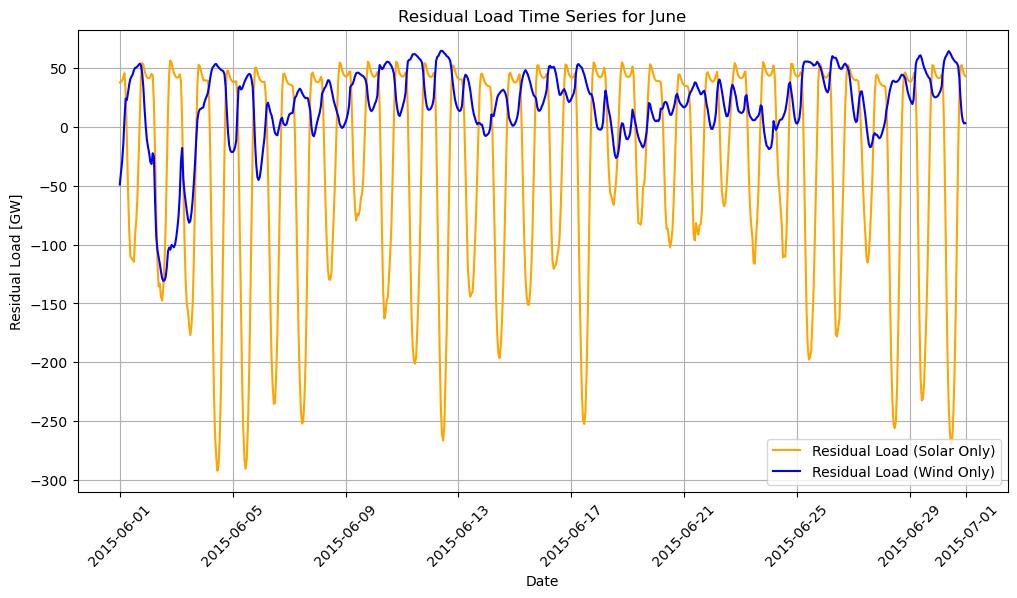

In [63]:
import matplotlib.pyplot as plt

# Filter data for June
june_data = df[df.index.month == 6]

# Plot residual load time series
plt.figure(figsize=(12, 6))
plt.plot(june_data.index, june_data["residual_load_solar"], label="Residual Load (Solar Only)", color="orange")
plt.plot(june_data.index, june_data["residual_load_wind"], label="Residual Load (Wind Only)", color="blue")

# Formatting the plot
plt.xlabel("Date")
plt.ylabel("Residual Load [GW]")
plt.title("Residual Load Time Series for June")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

# Show plot
plt.show()


## E) Compute state-of-charge time series for the minimum storage needed to flatten the residual load in both scenarios.

/var/folders/8c/v91_jry14xzffqqmf6k70y700000gn/T/ipykernel_69016/1783126011.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '41.151' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[df.index[i], "storage_solar"] = max(solar_soc, 0)  # Ensure SOC remains non-negative
/var/folders/8c/v91_jry14xzffqqmf6k70y700000gn/T/ipykernel_69016/1783126011.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '22.861054200989976' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[df.index[i], "storage_wind"] = max(wind_soc, 0)  # Ensure SOC remains non-negative


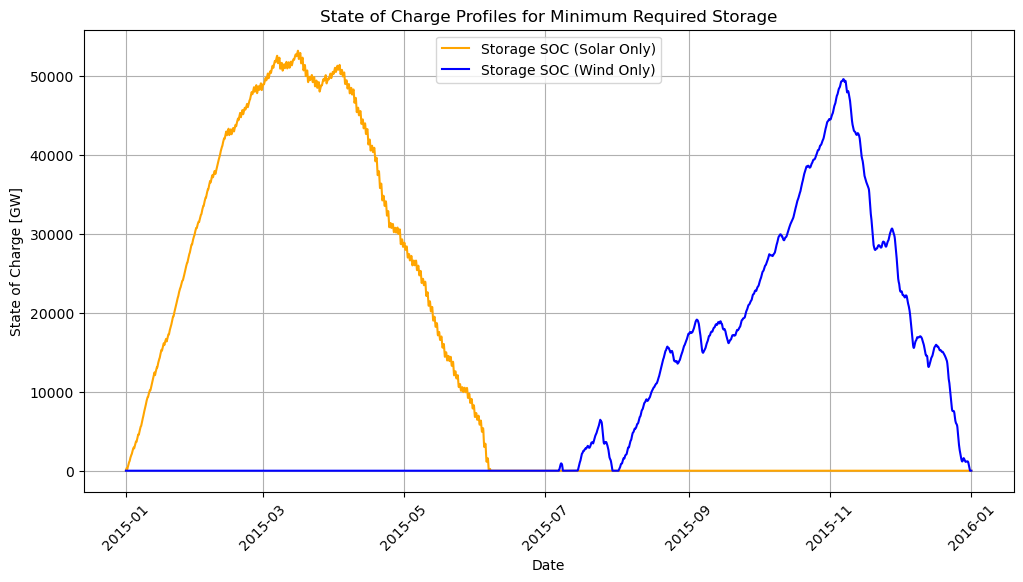

In [64]:
# Initialize storage SOC for solar-only and wind-only scenarios
df["storage_solar"] = 0
df["storage_wind"] = 0

# Iterate over the time series to compute the SOC dynamically
solar_soc, wind_soc = 0, 0  # Initial state of charge

for i in range(len(df)):
    # Solar scenario
    solar_soc += df.iloc[i]["residual_load_solar"]  # Add surplus or deficit
    df.at[df.index[i], "storage_solar"] = max(solar_soc, 0)  # Ensure SOC remains non-negative

    # Wind scenario
    wind_soc += df.iloc[i]["residual_load_wind"]  # Add surplus or deficit
    df.at[df.index[i], "storage_wind"] = max(wind_soc, 0)  # Ensure SOC remains non-negative

# Plot SOC time series
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["storage_solar"], label="Storage SOC (Solar Only)", color="orange")
plt.plot(df.index, df["storage_wind"], label="Storage SOC (Wind Only)", color="blue")

# Formatting the plot
plt.xlabel("Date")
plt.ylabel("State of Charge [GW]")
plt.title("State of Charge Profiles for Minimum Required Storage")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

# Show plot
plt.show()


## F) Report required:
Energy capacity [GWh],
Charge capacity [GW],
Discharge capacity [GW],
for both solar- and wind-only cases.

In [65]:
# Compute required energy storage capacity (max SOC in GWh)
required_energy_solar = df["storage_solar"].max()
required_energy_wind = df["storage_wind"].max()

# Compute charge capacity (max positive change in SOC per time step)
required_charge_solar = df["storage_solar"].diff().max()
required_charge_wind = df["storage_wind"].diff().max()

# Compute discharge capacity (max negative change in SOC per time step)
required_discharge_solar = df["storage_solar"].diff().min()
required_discharge_wind = df["storage_wind"].diff().min()

# Print results
print(f"Required Energy Storage Capacity:")
print(f"   - Solar-based system: {required_energy_solar:.2f} GWh")
print(f"   - Wind-based system: {required_energy_wind:.2f} GWh")

print(f"\n Required Charge Capacity:")
print(f"   - Solar-based system: {required_charge_solar:.2f} GW")
print(f"   - Wind-based system: {required_charge_wind:.2f} GW")

print(f"\n Required Discharge Capacity:")
print(f"   - Solar-based system: {abs(required_discharge_solar):.2f} GW")  # Convert negative discharge to positive
print(f"   - Wind-based system: {abs(required_discharge_wind):.2f} GW")


Required Energy Storage Capacity:
   - Solar-based system: 53215.06 GWh
   - Wind-based system: 49614.16 GWh

 Required Charge Capacity:
   - Solar-based system: 72.85 GW
   - Wind-based system: 67.51 GW

 Required Discharge Capacity:
   - Solar-based system: 300.04 GW
   - Wind-based system: 195.00 GW


## G) Define a function to calculate residual load for any wind share 𝛼 ∈ [0, 1].

In [66]:
def compute_residual_load(df, alpha):
    """
    Computes residual load as a function of wind generation share α.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing 'onwind [GW]', 'solar [GW]', and 'load [GW]'
        alpha (float): Wind generation share (0 ≤ α ≤ 1)
    
    Returns:
        pd.Series: Residual load time series
    """
    # Ensure alpha is within valid bounds
    if not (0 <= alpha <= 1):
        raise ValueError("Alpha must be between 0 and 1.")

    # Compute mixed generation
    generation_mix = alpha * df["onwind [GW]"] + (1 - alpha) * df["solar [GW]"]

    # Compute residual load
    residual_load = df["load [GW]"] - generation_mix
    
    return residual_load

# Example usage:
# alpha = 0.6  # 60% wind, 40% solar
# df["residual_load_mix"] = compute_residual_load(df, alpha)
# print(df[["residual_load_mix"]].head())


## H) Apply this function in 5% steps and store each residual load time series in a DataFrame.

In [68]:
# Define alpha values (from 0% to 100% in steps of 5%)
alpha_values = np.arange(0, 1.05, 0.05)  # Increment by 5% (0.05)

# Initialize DataFrame for storing residual load time series
residual_load_df = pd.DataFrame(index=df.index)

# Compute residual load for each alpha value and store in DataFrame
for alpha in alpha_values:
    residual_load_df[f"alpha_{alpha:.2f}"] = compute_residual_load(df, alpha)

# Display first 5 rows and columns
residual_load_df.iloc[:5, :5]


,alpha_0.00,alpha_0.05,alpha_0.10,alpha_0.15,alpha_0.20
2015-01-01 00:00:00,41.151,39.065973,36.980946,34.895919,32.810892
2015-01-01 01:00:00,40.135,37.926150,35.717299,33.508449,31.299598
2015-01-01 02:00:00,39.106,36.781315,34.456630,32.131944,29.807259
2015-01-01 03:00:00,38.765,36.441646,34.118292,31.794939,29.471585
2015-01-01 04:00:00,38.941,36.509800,34.078600,31.647400,29.216200


## I) Plot required charge/discharge capacities vs. wind share 𝛼.

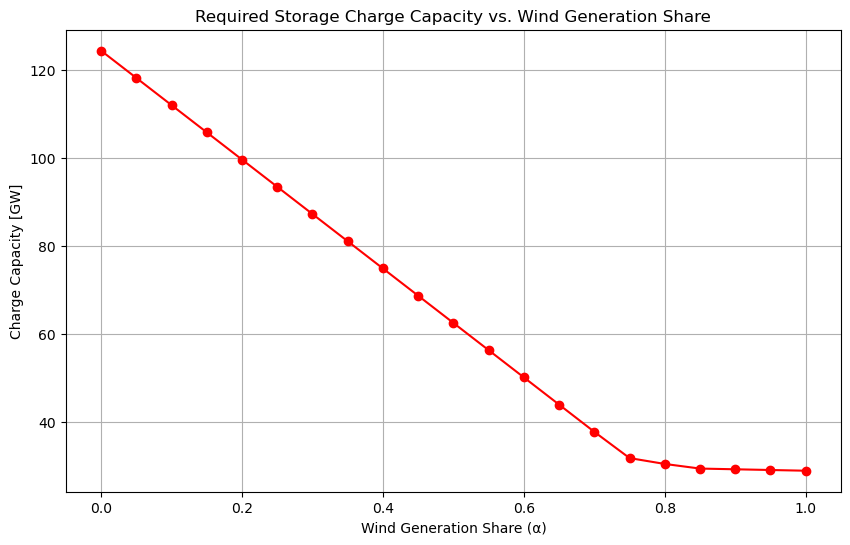

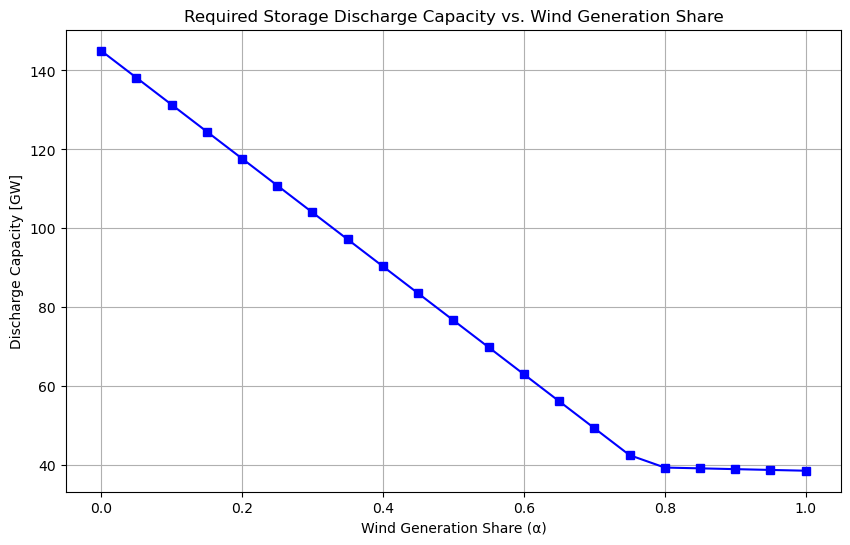

In [70]:
import matplotlib.pyplot as plt
import numpy as np

# Define alpha values (from 0% to 100% in steps of 5%)
alpha_values = np.arange(0, 1.05, 0.05)

# Initialize lists to store results
charge_capacities = []
discharge_capacities = []

# Compute charge and discharge capacities for each α
for alpha in alpha_values:
    residual_load = compute_residual_load(df, alpha)
    
    # Compute charge and discharge capacity
    charge_capacity = residual_load.diff().max()  # Max positive change (charging)
    discharge_capacity = residual_load.diff().min()  # Max negative change (discharging)
    
    charge_capacities.append(charge_capacity)
    discharge_capacities.append(abs(discharge_capacity))  # Convert discharge to positive

# Plot charge capacity
plt.figure(figsize=(10, 6))
plt.plot(alpha_values, charge_capacities, marker="o", color="red")
plt.xlabel("Wind Generation Share (α)")
plt.ylabel("Charge Capacity [GW]")
plt.title("Required Storage Charge Capacity vs. Wind Generation Share")
plt.grid(True)
plt.show()

# Plot discharge capacity
plt.figure(figsize=(10, 6))
plt.plot(alpha_values, discharge_capacities, marker="s", color="blue")
plt.xlabel("Wind Generation Share (α)")
plt.ylabel("Discharge Capacity [GW]")
plt.title("Required Storage Discharge Capacity vs. Wind Generation Share")
plt.grid(True)
plt.show()


## J)Plot required energy storage capacity vs. 𝛼.

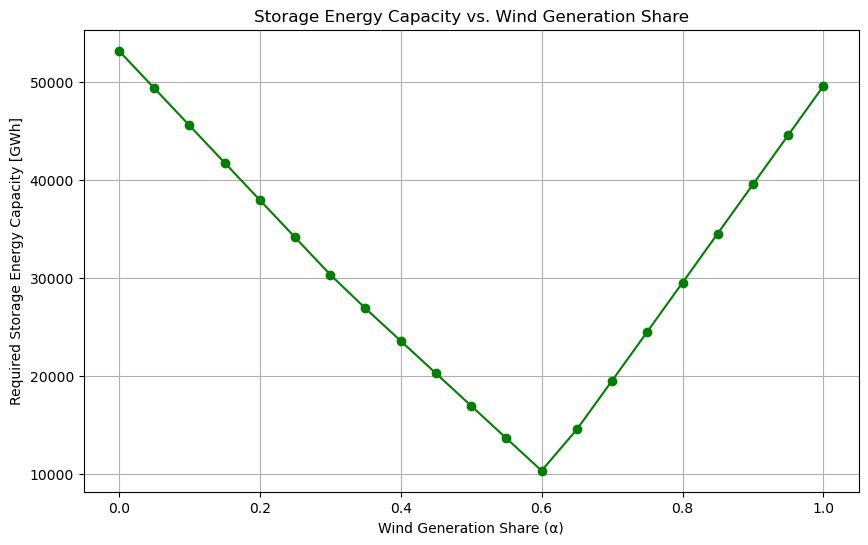

In [71]:
# Initialize list to store required energy capacities
energy_capacities = []

# Compute required storage energy capacity for each α
for alpha in alpha_values:
    residual_load = compute_residual_load(df, alpha)
    
    # Required storage energy capacity (max SOC)
    required_energy = residual_load.cumsum().max()  # Maximum cumulative surplus storage needed
    energy_capacities.append(required_energy)

# Plot required storage energy capacity
plt.figure(figsize=(10, 6))
plt.plot(alpha_values, energy_capacities, marker="o", color="green")

# Formatting the plot
plt.xlabel("Wind Generation Share (α)")
plt.ylabel("Required Storage Energy Capacity [GWh]")
plt.title("Storage Energy Capacity vs. Wind Generation Share")
plt.grid(True)

# Show plot
plt.show()


## k) Identify the optimal 𝛼 that minimizes energy storage needs.

In [72]:
# Identify the α value corresponding to the lowest energy capacity
optimal_alpha = alpha_values[np.argmin(energy_capacities)]
optimal_energy_capacity = min(energy_capacities)

print(f"Optimal Wind Generation Share (α): {optimal_alpha:.2f}")
print(f"Minimum Required Storage Energy Capacity: {optimal_energy_capacity:.2f} GWh")


Optimal Wind Generation Share (α): 0.60
Minimum Required Storage Energy Capacity: 10349.67 GWh


## L) Plot state-of-charge for this optimal 𝛼 and compare it with 100% wind/solar cases. Briefly explain the benefits of mixing technologies.

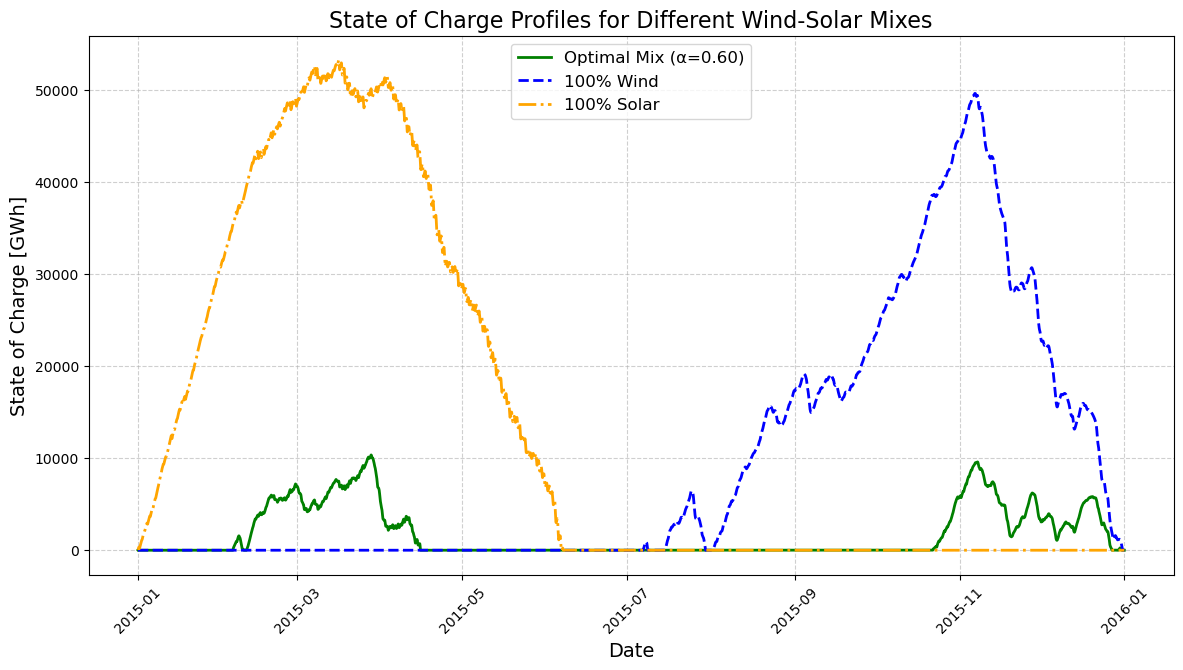

In [74]:
import matplotlib.pyplot as plt

# Compute SOC profiles for different α values
alpha_optimal = optimal_alpha  # The α that minimizes storage requirement
residual_load_optimal = compute_residual_load(df, alpha_optimal)
residual_load_wind = compute_residual_load(df, 1)  # 100% wind
residual_load_solar = compute_residual_load(df, 0)  # 100% solar

# Compute cumulative SOC profiles
df["storage_optimal"] = residual_load_optimal.cumsum().clip(lower=0)
df["storage_wind"] = residual_load_wind.cumsum().clip(lower=0)
df["storage_solar"] = residual_load_solar.cumsum().clip(lower=0)

# Improve graph readability
plt.figure(figsize=(14, 7))
plt.plot(df.index, df["storage_optimal"], label=f"Optimal Mix (α={alpha_optimal:.2f})", color="green", linestyle="-", linewidth=2)
plt.plot(df.index, df["storage_wind"], label="100% Wind", color="blue", linestyle="--", linewidth=2)
plt.plot(df.index, df["storage_solar"], label="100% Solar", color="orange", linestyle="-.", linewidth=2)

# Enhance formatting
plt.xlabel("Date", fontsize=14)
plt.ylabel("State of Charge [GWh]", fontsize=14)
plt.title("State of Charge Profiles for Different Wind-Solar Mixes", fontsize=16)
plt.legend(fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)

# Show plot
plt.show()


## M) Add seasonal electric heating demand:
Create sinusoidal heating load with amplitude = 0.5 × mean electric load.
Recalculate optimal 𝛼 and compare: does seasonal heating shift the storage-optimal mix?

In [76]:
# Compute mean and amplitude of original load profile
mean_load = df["load [GW]"].mean()
amplitude_load = mean_load / 2  # Amplitude is half of mean

# Generate additional seasonal load profile
df["heating_load [GW]"] = pd.Series(
    mean_load + amplitude_load * np.cos(2 * np.pi * df.index.dayofyear / 365), 
    index=df.index
)

# Update total electricity demand
df["total_load [GW]"] = df["load [GW]"] + df["heating_load [GW]"]

# Compute required storage energy capacity for different α values with new total load
energy_capacities_new = []

for alpha in alpha_values:
    residual_load_new = df["total_load [GW]"] - (alpha * df["onwind [GW]"] + (1 - alpha) * df["solar [GW]"])
    required_energy_new = residual_load_new.cumsum().max()  # Max cumulative storage requirement
    energy_capacities_new.append(required_energy_new)

# Find the new optimal α
optimal_alpha_new = alpha_values[np.argmin(energy_capacities_new)]
optimal_energy_capacity_new = min(energy_capacities_new)

print(f" New Optimal Wind Generation Share (α) with Heating Load: {optimal_alpha_new:.2f}")
print(f" Minimum Required Storage Energy Capacity with Heating Load: {optimal_energy_capacity_new:.2f} GWh")


 New Optimal Wind Generation Share (α) with Heating Load: 0.05
 Minimum Required Storage Energy Capacity with Heating Load: 479496.05 GWh


## Task 3

## A) Load the water flow dataset as a pandas.Series with parsed dates and confirm that the index is of type DatetimeIndex.

In [80]:
import pandas as pd

# Load dataset as pandas Series with parsed dates
file_url = "https://tubcloud.tu-berlin.de/s/af5G99i35dwNPCz/download/water-flows.csv"
df = pd.read_csv(file_url, index_col=0, parse_dates=True)

# Confirm index type
print(f"Index Type: {type(df.index)}")

# Show first few rows
df.head()


Index Type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


,Scaled Flow
Date,
1983-01-01,1.445017
1983-01-02,1.808810
1983-01-03,3.476350
1983-01-04,1.963007
1983-01-05,4.854887


## B) Resample the time series to calculate monthly mean flow rates, and plot the result using a wide figure (20×4 inches) with properly labeled axes and units (m³/s).

/var/folders/8c/v91_jry14xzffqqmf6k70y700000gn/T/ipykernel_69016/3629022355.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_mean_flow = df.resample("M").mean()


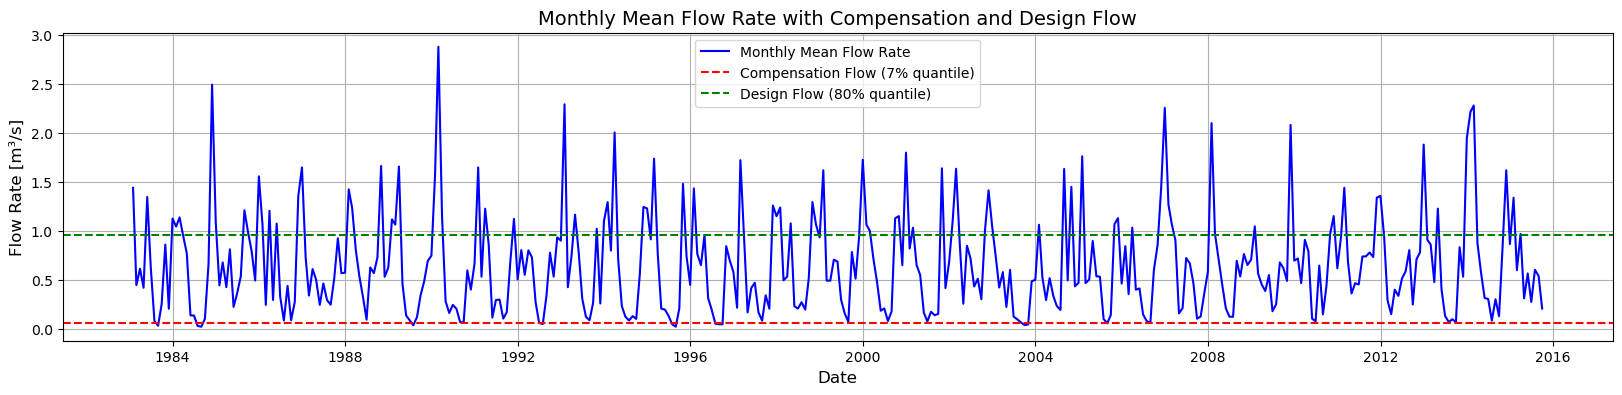

In [81]:

# Compute monthly mean flow rate
monthly_mean_flow = df.resample("M").mean()

# Compute compensation flow (7% quantile)
compensation_flow = df.quantile(0.07)

# Compute design flow (80% quantile)
design_flow = df.quantile(0.80)

# Plot monthly resampled mean flow rate
plt.figure(figsize=(20, 4))
plt.plot(monthly_mean_flow.index, monthly_mean_flow.values, label="Monthly Mean Flow Rate", color="blue")
plt.axhline(compensation_flow.values, color="red", linestyle="--", label="Compensation Flow (7% quantile)")
plt.axhline(design_flow.values, color="green", linestyle="--", label="Design Flow (80% quantile)")

# Formatting
plt.xlabel("Date", fontsize=12)
plt.ylabel("Flow Rate [m³/s]", fontsize=12)
plt.title("Monthly Mean Flow Rate with Compensation and Design Flow", fontsize=14)
plt.legend()
plt.grid(True)

# Show plot
plt.show()


## c) Calculate the compensation flow, defined as the 7th percentile of all recorded flows.

In [82]:
compensation_flow = df.quantile(0.07)
print(f"Compensation Flow: {compensation_flow.values[0]:.2f} m³/s")


Compensation Flow: 0.06 m³/s


## D) Determine the design flow, which is the 80th percentile value of the daily flows.

In [83]:
design_flow = df.quantile(0.80)
print(f"Design Flow: {design_flow.values[0]:.2f} m³/s")


Design Flow: 0.96 m³/s


## E) Create a new time series representing available flow for power production: flows are capped at the design flow and reduced by the compensation flow, with negative values set to zero.

In [87]:
# Compute available flow for power production
df["available_flow"] = df["Scaled Flow"].clip(lower=compensation_flow.values[0], upper=design_flow.values[0])

# Deduct compensation flow
df["available_flow"] -= compensation_flow.values[0]

# Ensure no negative values
df["available_flow"] = df["available_flow"].clip(lower=0)

# Display first few rows
print(df[["Scaled Flow", "available_flow"]].head())

            Scaled Flow  available_flow
Date                                   
1983-01-01     1.445017        0.897185
1983-01-02     1.808810        0.897185
1983-01-03     3.476350        0.897185
1983-01-04     1.963007        0.897185
1983-01-05     4.854887        0.897185


## F) Plot a duration curve showing both the full river flow and the available flow over the 30-year period. X-axis should show the percentage of time exceeded, and the Y-axis should be capped at 3 m³/s for clarity.

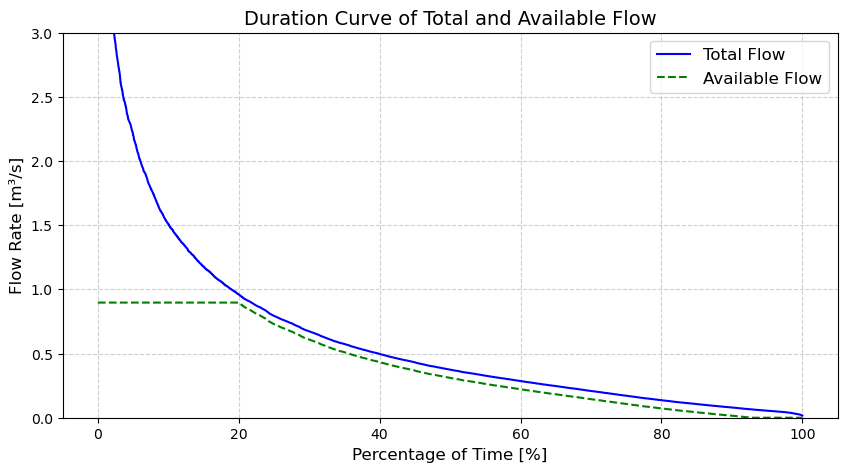

In [88]:

# Sort flow values in descending order for duration curves
sorted_total_flow = np.sort(df["Scaled Flow"])[::-1]  # Total flow (descending order)
sorted_available_flow = np.sort(df["available_flow"])[::-1]  # Available flow (descending order)

# Compute percentage of time (x-axis)
time_percent = np.linspace(0, 100, len(df))

# Plot duration curves
plt.figure(figsize=(10, 5))
plt.plot(time_percent, sorted_total_flow, label="Total Flow", color="blue", linestyle="-")
plt.plot(time_percent, sorted_available_flow, label="Available Flow", color="green", linestyle="--")

# Formatting
plt.xlabel("Percentage of Time [%]", fontsize=12)
plt.ylabel("Flow Rate [m³/s]", fontsize=12)
plt.title("Duration Curve of Total and Available Flow", fontsize=14)
plt.legend(fontsize=12)
plt.ylim(0, 3)  # Limit y-axis to 3 m³/s
plt.grid(True, linestyle="--", alpha=0.6)

# Show plot
plt.show()


## G) Compute the rated power of the plant using the design flow, net head (48 m), water density, gravity, and generator efficiency (92%).

In [89]:
# Constants
efficiency = 0.92  # Generator efficiency (92%)
density = 1000  # Water density (kg/m³)
gravity = 9.81  # Gravitational acceleration (m/s²)
head = 48  # Net head (m)

# Use the design flow computed earlier
design_flow = design_flow.values[0]  # Convert from DataFrame format to float

# Compute power in watts
rated_power_watts = efficiency * density * gravity * design_flow * head

# Convert to megawatts (MW)
rated_power_MW = rated_power_watts / 1e6

print(f" Rated Power of Run-of-River Scheme: {rated_power_MW:.2f} MW")


 Rated Power of Run-of-River Scheme: 0.42 MW


## H) Calculate a time series of daily electricity generation in kWh, based on daily available flow and system parameters.

In [90]:
# Constants
efficiency = 0.92  # Generator efficiency (92%)
density = 1000  # Water density (kg/m³)
gravity = 9.81  # Gravitational acceleration (m/s²)
head = 48  # Net head (m)
seconds_per_day = 86400  # Total seconds in a day (24 hours * 60 min * 60 sec)

# Compute daily electricity production in kWh
df["daily_energy_kWh"] = (
    efficiency * density * gravity * df["available_flow"] * head * seconds_per_day / 1000  # Convert W to kWh
)

# Display first few rows
print(df[["available_flow", "daily_energy_kWh"]].head())


            available_flow  daily_energy_kWh
Date                                        
1983-01-01        0.897185      3.358100e+07
1983-01-02        0.897185      3.358100e+07
1983-01-03        0.897185      3.358100e+07
1983-01-04        0.897185      3.358100e+07
1983-01-05        0.897185      3.358100e+07


## I) Compute the long-term average capacity factor of the plant using the actual energy produced and the theoretical maximum energy at rated power.

In [92]:
# Compute total actual energy output over the dataset
total_actual_energy_kWh = df["daily_energy_kWh"].sum()  # kWh

# Compute total possible energy output (rated power * total hours)
rated_power_kW = rated_power_MW * 1e3  # Convert MW to kW
total_hours = len(df) * 24  # Total hours in dataset
total_possible_energy_kWh = rated_power_kW * total_hours  # Max possible production

# Compute capacity factor
capacity_factor = (total_actual_energy_kWh / total_possible_energy_kWh) * 100

print(f"Long-term Average Capacity Factor: {capacity_factor:.2f}%")


Long-term Average Capacity Factor: 150412.98%


## J) Plot the annual energy yield from 1983 to 2014 by grouping daily production data by year and summing.

/var/folders/8c/v91_jry14xzffqqmf6k70y700000gn/T/ipykernel_69016/1913059376.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_energy_yield = df["daily_energy_kWh"].resample("Y").sum()


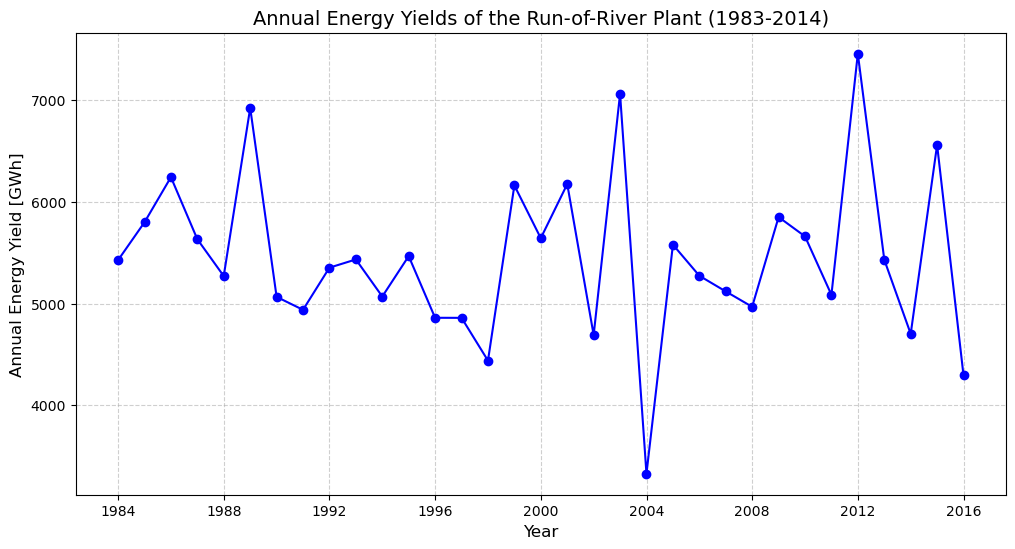

In [93]:

# Compute annual energy yields (sum of daily energy production per year)
annual_energy_yield = df["daily_energy_kWh"].resample("Y").sum()

# Convert to GWh for better readability
annual_energy_yield_GWh = annual_energy_yield / 1e6

# Plot annual energy yields
plt.figure(figsize=(12, 6))
plt.plot(annual_energy_yield_GWh.index, annual_energy_yield_GWh.values, marker="o", linestyle="-", color="blue")

# Formatting
plt.xlabel("Year", fontsize=12)
plt.ylabel("Annual Energy Yield [GWh]", fontsize=12)
plt.title("Annual Energy Yields of the Run-of-River Plant (1983-2014)", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)

# Show plot
plt.show()


## k) Plot the relative deviation (in %) of each year’s yield from the long-term average. Highlight underperforming years with negative values.

/var/folders/8c/v91_jry14xzffqqmf6k70y700000gn/T/ipykernel_69016/2029196978.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_energy_yield_GWh = df["daily_energy_kWh"].resample("Y").sum() / 1e6  # Convert kWh to GWh


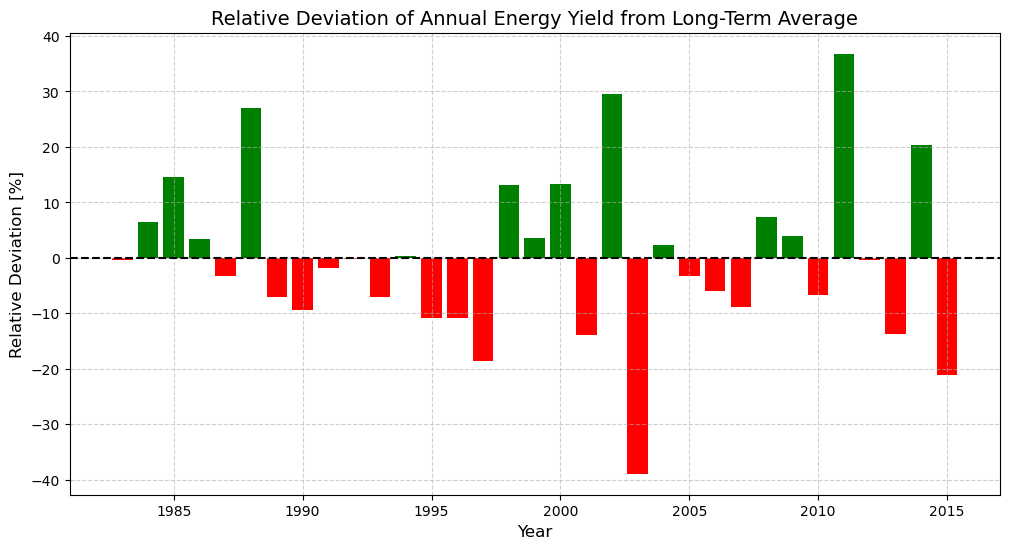

In [94]:

# Compute annual energy yields
annual_energy_yield_GWh = df["daily_energy_kWh"].resample("Y").sum() / 1e6  # Convert kWh to GWh

# Compute long-term average yield
long_term_avg_yield = annual_energy_yield_GWh.mean()

# Compute relative deviation in %
relative_deviation = ((annual_energy_yield_GWh - long_term_avg_yield) / long_term_avg_yield) * 100

# Plot relative deviation
plt.figure(figsize=(12, 6))
plt.bar(relative_deviation.index.year, relative_deviation.values, color=["red" if v < 0 else "green" for v in relative_deviation.values])

# Formatting
plt.xlabel("Year", fontsize=12)
plt.ylabel("Relative Deviation [%]", fontsize=12)
plt.title("Relative Deviation of Annual Energy Yield from Long-Term Average", fontsize=14)
plt.axhline(0, color="black", linestyle="--")  # Reference line at 0%
plt.grid(True, linestyle="--", alpha=0.6)

# Show plot
plt.show()


## L) Perform a design flow sensitivity analysis:
Loop through design flow percentiles (0% to 100% in 5% steps),
Calculate rated power and resulting average annual generation for each,
Plot energy yield vs. power rating and discuss diminishing returns or plateauing effect.

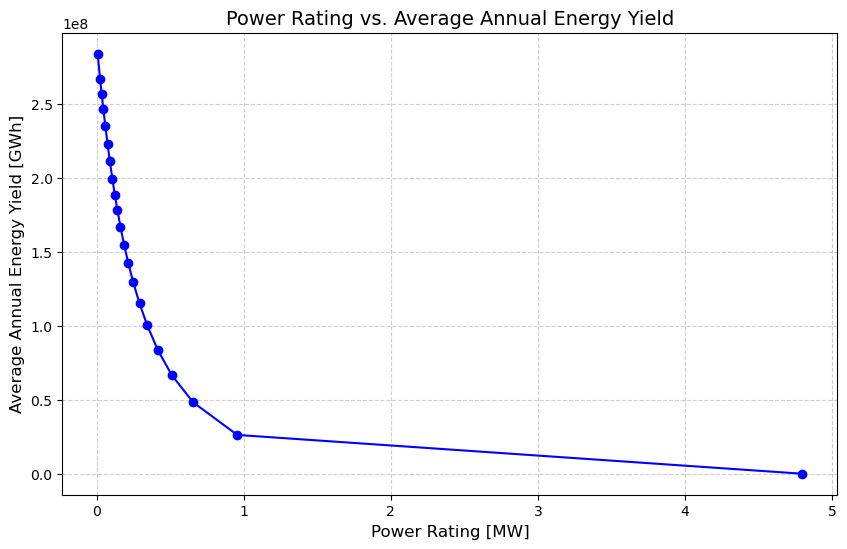

In [95]:

# Define design flow quantiles (0% to 100% in steps of 5%)
quantiles = np.arange(0, 1.05, 0.05)
design_flows = df["Scaled Flow"].quantile(quantiles)  # Compute flow values at each quantile

# Constants for power calculation
efficiency = 0.92  # Generator efficiency (92%)
density = 1000  # Water density (kg/m³)
gravity = 9.81  # Gravitational acceleration (m/s²)
head = 48  # Net head (m)
seconds_per_day = 86400  # Total seconds in a day (24 hours * 60 min * 60 sec)

# Compute power rating for each design flow
power_ratings_MW = efficiency * density * gravity * design_flows * head / 1e6  # Convert to MW

# Compute annual energy yield for each design flow
annual_energy_yields_GWh = []
for flow in design_flows:
    available_flow = df["Scaled Flow"].clip(lower=flow).sum() - flow * len(df)  # Deduct reserve flow
    annual_energy = efficiency * density * gravity * available_flow * head * seconds_per_day / 1e6  # Convert to GWh
    annual_energy_yields_GWh.append(annual_energy)

# Plot relationship
plt.figure(figsize=(10, 6))
plt.plot(power_ratings_MW, annual_energy_yields_GWh, marker="o", linestyle="-", color="blue")

# Formatting
plt.xlabel("Power Rating [MW]", fontsize=12)
plt.ylabel("Average Annual Energy Yield [GWh]", fontsize=12)
plt.title("Power Rating vs. Average Annual Energy Yield", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)

# Show plot
plt.show()


## M) Investigate how compensation flow affects generation:
Compare annual energy yields using a compensation flow set at the 7% and the 3% flow quantiles,
Report both the absolute and percentage decrease in average annual energy output due to stricter environmental limits.


In [96]:
# Compute compensation flows for 7% and 3% quantiles
comp_flow_7 = df["Scaled Flow"].quantile(0.07)
comp_flow_3 = df["Scaled Flow"].quantile(0.03)

# Compute available flows for both cases
df["available_flow_7"] = df["Scaled Flow"].clip(lower=comp_flow_7) - comp_flow_7
df["available_flow_3"] = df["Scaled Flow"].clip(lower=comp_flow_3) - comp_flow_3

# Ensure no negative values
df["available_flow_7"] = df["available_flow_7"].clip(lower=0)
df["available_flow_3"] = df["available_flow_3"].clip(lower=0)

# Compute annual energy yields
annual_yield_7 = df["available_flow_7"].resample("Y").sum() * efficiency * density * gravity * head * seconds_per_day / 1e6  # Convert to GWh
annual_yield_3 = df["available_flow_3"].resample("Y").sum() * efficiency * density * gravity * head * seconds_per_day / 1e6  # Convert to GWh

# Compute long-term averages
avg_yield_7 = annual_yield_7.mean()
avg_yield_3 = annual_yield_3.mean()

# Calculate absolute and relative decrease
absolute_decrease = avg_yield_7 - avg_yield_3
relative_decrease = (absolute_decrease / avg_yield_7) * 100

print(f" Average Annual Energy Yield with 7% Compensation Flow: {avg_yield_7:.2f} GWh")
print(f" Average Annual Energy Yield with 3% Compensation Flow: {avg_yield_3:.2f} GWh")
print(f" Absolute Decrease: {absolute_decrease:.2f} GWh")
print(f" Relative Decrease: {relative_decrease:.2f}%")


 Average Annual Energy Yield with 7% Compensation Flow: 7984081.23 GWh
 Average Annual Energy Yield with 3% Compensation Flow: 8217494.56 GWh
 Absolute Decrease: -233413.33 GWh
 Relative Decrease: -2.92%


/var/folders/8c/v91_jry14xzffqqmf6k70y700000gn/T/ipykernel_69016/123613531.py:14: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_yield_7 = df["available_flow_7"].resample("Y").sum() * efficiency * density * gravity * head * seconds_per_day / 1e6  # Convert to GWh
/var/folders/8c/v91_jry14xzffqqmf6k70y700000gn/T/ipykernel_69016/123613531.py:15: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_yield_3 = df["available_flow_3"].resample("Y").sum() * efficiency * density * gravity * head * seconds_per_day / 1e6  # Convert to GWh
